# K-Means Clustering
![](https://miro.medium.com/max/1280/1*5UHmgCaTD8EegsPuKcxC1Q.png)

In [30]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
sns.set()
sns.set_style('whitegrid')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris
%matplotlib inline

## Introducing k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an unlabeled multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

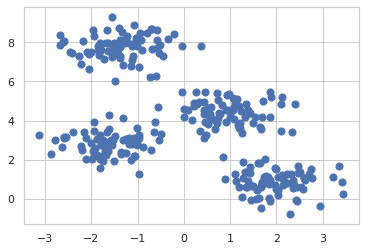

In [31]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

By eye, it is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [32]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

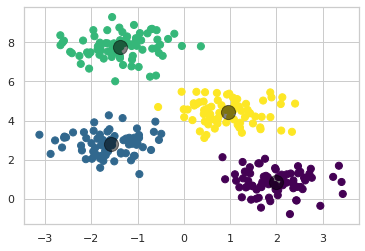

In [33]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## k-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm, and we will walk through it briefly here.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
   1. *E-Step*: assign points to the nearest cluster center
   2. *M-Step*: set the cluster centers to the mean 

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.
![](https://raw.githubusercontent.com/jakevdp/PythonDataScienceHandbook/8a34a4f653bdbdc01415a94dc20d4e9b97438965/notebooks/figures/05.11-expectation-maximization.png)

The *k*-Means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation:

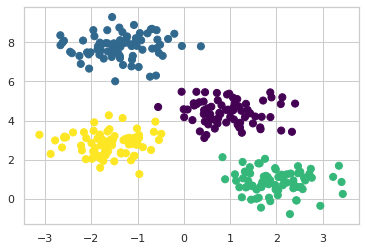

In [34]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Most well-tested implementations will do a bit more than this under the hood, but the preceding function gives the gist of the expectation–maximization approach.

### Caveats of expectation–maximization

There are a few issues to be aware of when using the expectation–maximization algorithm.

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

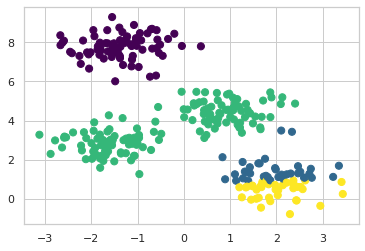

In [35]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

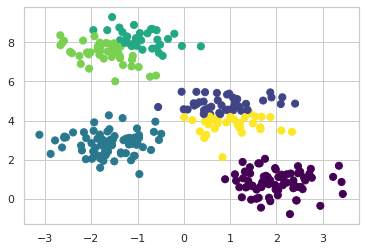

In [36]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

## Elbow Method - Determine optimal no. of clusters
![](https://media.geeksforgeeks.org/wp-content/uploads/20190606105550/distortion1.png)

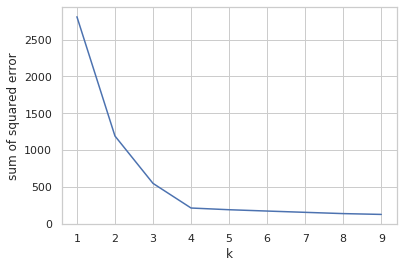

In [37]:
k_rng =range(1,10)
sse = []
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)
    
plt.xlabel('k')
plt.ylabel('sum of squared error')
plt.plot(k_rng,sse)
#It appears that 4 clusters is optimal

## K-Means for Iris data
![](https://es.mathworks.com/help/examples/fuzzy/win64/irisfcm_01.png)

In [38]:
iris =load_iris()
df = pd.DataFrame(iris.data,columns=iris.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [39]:
df['flower']=iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),flower
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [40]:
df.drop(['sepal length (cm)','sepal width (cm)','flower'], axis='columns', inplace=True)
df.head(3)

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2


In [41]:
km= KMeans(n_clusters=3)
yp=km.fit_predict(df)
yp

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [42]:
df['cluster']= yp
df.head()

,petal length (cm),petal width (cm),cluster
0,1.4,0.2,0
1,1.4,0.2,0
2,1.3,0.2,0
3,1.5,0.2,0
4,1.4,0.2,0


In [43]:
df.cluster.unique()

array([0, 2, 1], dtype=int32)

In [44]:
df1= df[df.cluster==0]
df2= df[df.cluster==1]
df3= df[df.cluster==2]

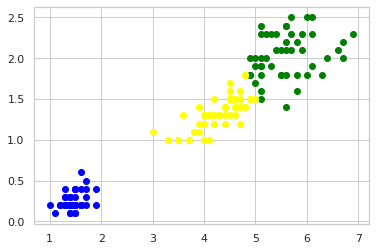

In [45]:
plt.scatter(df1['petal length (cm)'],df1['petal width (cm)'],color='blue')
plt.scatter(df2['petal length (cm)'],df2['petal width (cm)'],color='green')
plt.scatter(df3['petal length (cm)'],df3['petal width (cm)'],color='yellow')

In [46]:
sse = []
k_rng = range(1,10)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df)
    sse.append(km.inertia_)

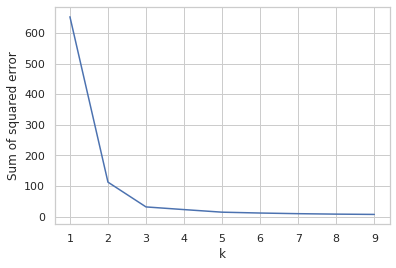

In [47]:
plt.xlabel('k')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

# K-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

In [19]:
from sklearn.datasets import make_moons
X, y = make_moons(1000, noise=0.03, random_state=0)

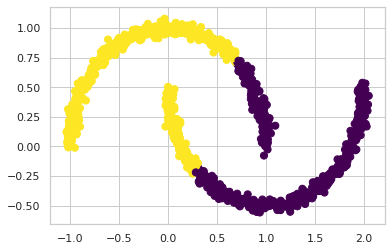

In [20]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

## Kernelized *k*-means: ``SpectralClustering`` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm:
![](https://miro.medium.com/max/1292/0*w_8-ldP7uCaLOBzZ.png)

/home/hieutt/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


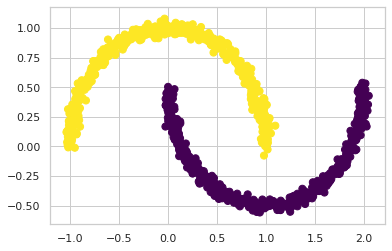

In [21]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

# DBSCAN
![](https://user-images.githubusercontent.com/7659/74451662-d2325000-4e34-11ea-9770-a57e81259eb9.png)

![](https://miro.medium.com/proxy/1*tc8UF-h0nQqUfLC8-0uInQ.gif)

In [22]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps=0.3, min_samples=50).fit(X)
labels = model.labels_
labels

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,

In [23]:
unique, count = np.unique([labels], return_counts=True)
outliers_groups_info = np.asarray((unique, count))

In [24]:
print(outliers_groups_info)
# -1 ==> outliers

[[  0   1]
 [500 500]]


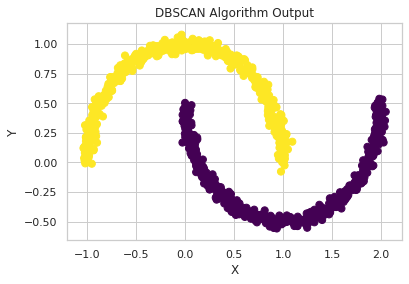

In [25]:
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis')
plt.xlabel("Χ")
plt.ylabel("Υ")
plt.title("DBSCAN Algorithm Output");

# For the anomaly points black/purple color has been given.

In [26]:
unique, count

(array([0, 1]), array([500, 500]))